In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as pylab
import pandas as pd
import cv2

In [15]:
url = r'C:\Users\ACER\MIAS\all-mias-jpg'

df = pd.read_csv(r'C:\Users\ACER\MIAS\Info.txt', sep=" ")

img_name = []

for i in range(df.shape[0]):
        img_name.append(df.REFNUM[i]+ '.jpg')
img_name = np.array(img_name)
        
img_add = []
for i in range(df.shape[0]):
    img_add.append(url + '\\' + df.REFNUM[i]+ '.pg.jpg') 
img_add = np.array(img_add)

In [4]:
def preprocess_images():
    print("Reading images")
    img_preproc = []
    for i in range(df.shape[0]):
        img = cv2.imread(img_add[i], 0)
        #########################################################
        #yaha se shuru karo, img mein pic hai jispe kaam karna hai
        
        
        #########################################################
        img_preproc.append(img) #storing processed image in a list

In [5]:
preprocess_images()

Reading images


In [61]:
from skimage import io
from skimage import color

def right_orient_mammogram(image):
    left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
    right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])
    
    if(left_nonzero < right_nonzero):
        image = cv2.flip(image, 1)

    return image

def read_image(filename):
    image = io.imread(filename)
    image = color.rgb2gray(image)
    image = right_orient_mammogram(image)
    return image

In [7]:
from skimage.feature import canny
from skimage.filters import sobel

def apply_canny(image):
    canny_img = canny(image, 6)
    return sobel(canny_img)


In [8]:
from skimage.transform import hough_line, hough_line_peaks

def get_hough_lines(canny_img):
    h, theta, d = hough_line(canny_img)
    lines = list()
    print('\nAll hough lines')
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        print("Angle: {:.2f}, Dist: {:.2f}".format(np.degrees(angle), dist))
        x1 = 0
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        x2 = canny_img.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        lines.append({
            'dist': dist,
            'angle': np.degrees(angle),
            'point1': [x1, y1],
            'point2': [x2, y2]
        })
    
    return lines

In [9]:
def shortlist_lines(lines):
    MIN_ANGLE = 10
    MAX_ANGLE = 70
    MIN_DIST  = 5
    MAX_DIST  = 200
    
    shortlisted_lines = [x for x in lines if 
                          (x['dist']>=MIN_DIST) &
                          (x['dist']<=MAX_DIST) &
                          (x['angle']>=MIN_ANGLE) &
                          (x['angle']<=MAX_ANGLE)
                        ]
    print('\nShorlisted lines')
    for i in shortlisted_lines:
        print("Angle: {:.2f}, Dist: {:.2f}".format(i['angle'], i['dist']))
        
    return shortlisted_lines

In [10]:
from skimage.draw import polygon

def remove_pectoral(shortlisted_lines):
    shortlisted_lines.sort(key = lambda x: x['dist'])
    pectoral_line = shortlisted_lines[0]
    d = pectoral_line['dist']
    theta = np.radians(pectoral_line['angle'])
    
    x_intercept = d/np.cos(theta)
    y_intercept = d/np.sin(theta)
    
    return polygon([0, 0, y_intercept], [0, x_intercept, 0])

In [78]:
def display_image(filename):
    image = read_image(filename)
    image = resize(image, (360,150))
    canny_image = apply_canny(image)
    lines = get_hough_lines(canny_image)
    shortlisted_lines = shortlist_lines(lines)
    
    fig, axes = plt.subplots(1, 4, figsize=(15,10))
    fig.tight_layout(pad=3.0)
    plt.xlim(0,image.shape[1])
    plt.ylim(image.shape[0])
    
    
    axes[0].set_title('Right-oriented mammogram')
    axes[0].imshow(image, cmap=pylab.cm.gray)
    axes[0].axis('on') 
    
    axes[1].set_title('Hough Lines on Canny Edge Image')
    axes[1].imshow(canny_image, cmap=pylab.cm.gray)
    axes[1].axis('on')
    axes[1].set_xlim(0,image.shape[1])
    axes[1].set_ylim(image.shape[0])
    for line in lines:
        axes[1].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
        
    axes[2].set_title('Shortlisted Lines')
    axes[2].imshow(canny_image, cmap=pylab.cm.gray)
    axes[2].axis('on')
    axes[2].set_xlim(0,image.shape[1])
    axes[2].set_ylim(image.shape[0])
    for line in shortlisted_lines:
        axes[2].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
        
    rr, cc = remove_pectoral(shortlisted_lines)
    image[rr, cc] = 0
    axes[3].set_title('Pectoral muscle removed')
    axes[3].imshow(image, cmap=pylab.cm.gray)
    axes[3].axis('on')
    print(image.shape)
    plt.show()
    out_file = 'mammo_proc_3.jpg'
    io.imshow(image)
    io.imsave(os.path.join(out_dir, out_file), img_as_ubyte(image))

In [ ]:
from PIL import Image
import os, glob
out_dir = r'C:\Users\ACER\MIAS\pecs-removed'
for i in range(322):
    img = display_image(img_add[i])
    out_file = img_name[i] +'.jpg'
    img.save(os.path.join(out_dir, out_file))

In [ ]:
img = display_image(r'C:\Users\ACER\MIAS\all-mias-jpg\mdb002.pg.jpg')
out_file = 'mdb002.jpg'
img.save(os.path.join(out_dir, out_file))


All hough lines
Angle: 8.55, Dist: 133.67
Angle: -7.54, Dist: 67.59
Angle: 44.75, Dist: 259.83
Angle: 33.69, Dist: 227.79
Angle: -1.51, Dist: 91.62
Angle: -26.65, Dist: -2.50
Angle: 26.65, Dist: 202.76
Angle: 13.58, Dist: 154.70
Angle: -23.63, Dist: 7.51
Angle: -30.67, Dist: -17.52
Angle: -34.69, Dist: -30.54
Angle: -14.58, Dist: 40.55
Angle: -17.60, Dist: 29.54
Angle: -42.74, Dist: -56.57
Angle: -3.52, Dist: 144.69
Angle: 23.63, Dist: 191.75
Angle: -48.77, Dist: -73.59

Shorlisted lines
Angle: 13.58, Dist: 154.70
Angle: 23.63, Dist: 191.75


IndexError: index 360 is out of bounds for axis 0 with size 360

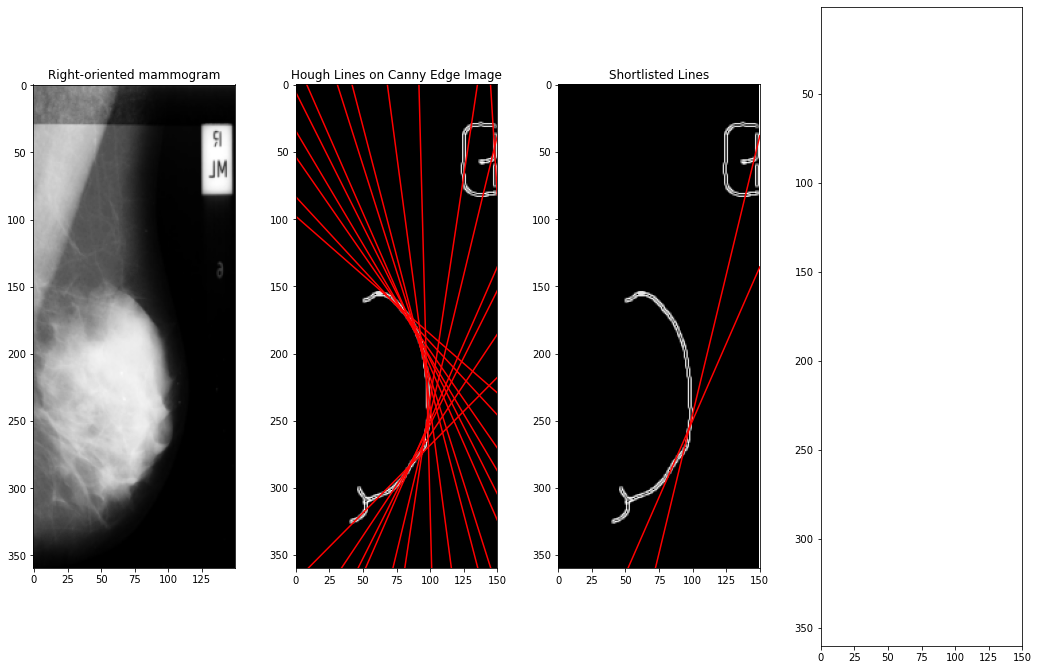

In [80]:
out_dir = r'C:\Users\ACER\MIAS\pecs-removed'
# img =
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import img_as_ubyte
display_image('mdb002.pg.jpg')
# display_image('mdb002.pg.jpg')

# out_file = 'mammo_preproc3.jpg'
# new_p = Image.fromarray(img)
# new_p = new_p.convert('RGB')
# new_p.save(os.path.join(out_dir, out_file))